<a href="https://colab.research.google.com/github/dookda/cmu_udfire_gee/blob/main/hotpred/predict_hp_lstm_gee_1y_nan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
# เริ่มต้นใช้งาน GEE
import ee
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import calendar

ee.Authenticate()
try:
    ee.Initialize(project="ee-sakda-451407")
except Exception as e:
    ee.Authenticate()
    ee.Initialize(project="ee-sakda-451407")

In [8]:
import folium

# กำหนดพื้นที่ศึกษา เชียงใหม่
# siteName = 'Mae Hong Son'
# siteName = 'Chiang Mai'
siteName = 'Nan'
# siteName = 'Uttaradit'
study_area = ee.FeatureCollection("FAO/GAUL/2015/level1").filter(ee.Filter.eq('ADM0_NAME', 'Thailand')).filter(ee.Filter.eq('ADM1_NAME', siteName))

# config figure height
f = folium.Figure(height=300)

# add map to figure
m = folium.Map(location=[18.9, 99.0], zoom_start=7).add_to(f)

# add study area to map
folium.GeoJson(study_area.getInfo()).add_to(m)

m

In [13]:
# ฟังก์ชันคำนวณ NDVI จาก MOD09Q1
def calculate_ndvi(image):
    try:
        # MOD09Q1 bands: sur_refl_b01 (red), sur_refl_b02 (NIR)
        nir = image.select('sur_refl_b02').multiply(0.0001)  # Apply scale factor
        red = image.select('sur_refl_b01').multiply(0.0001)  # Apply scale factor

        # คำนวณ NDVI
        ndvi = nir.subtract(red).divide(nir.add(red)).rename('NDVI')

        # กำหนดคุณสมบัติให้กับภาพ
        return image.addBands(ndvi).copyProperties(image, ['system:time_start'])
    except Exception as e:
        print(f"Error calculating NDVI: {e}")
        return None

# ฟังก์ชันดึงข้อมูล NDVI รายเดือนจาก MOD09Q1
def get_monthly_ndvi(start_date, end_date, study_area):
    try:
        # เรียกชุดข้อมูล MOD09Q1
        modis = ee.ImageCollection('MODIS/061/MOD09Q1') \
            .filterDate(start_date, end_date) \
            .filterBounds(study_area)

        # ตรวจสอบว่ามีข้อมูลหรือไม่
        size = modis.size().getInfo()
        print(f"จำนวนภาพ MODIS ดิบ: {size}")
        if size == 0:
            print("ไม่มีข้อมูล MOD09Q1 ในพื้นที่ศึกษา")
            return None

        # คำนวณ NDVI
        modis_ndvi = modis.map(calculate_ndvi)
        print(f"จำนวนภาพหลังคำนวณ NDVI: {modis_ndvi.size().getInfo()}")

        # เฉลี่ย NDVI เป็นรายเดือน
        def create_monthly_composite(year_month):
            year = ee.Number(year_month).divide(100).floor().int()
            month = ee.Number(year_month).mod(100).int()

            start = ee.Date.fromYMD(year, month, 1)
            end = start.advance(1, 'month')

            monthly_collection = modis_ndvi.filterDate(start, end)
            count = monthly_collection.size()

            # สร้างภาพเฉลี่ยรายเดือน
            monthly_mean = monthly_collection.mean() \
                .set('system:time_start', start.millis()) \
                .set('system:index', start.format('YYYY_MM')) \
                .set('year', year) \
                .set('month', month)

            return ee.Algorithms.If(
                count.gt(0),
                monthly_mean,
                ee.Image.constant(0).rename('NDVI') \
                    .set('system:time_start', start.millis()) \
                    .set('system:index', start.format('YYYY_MM')) \
                    .set('year', year) \
                    .set('month', month)
            )

        # สร้างรายการปี-เดือน
        start_year = int(start_date.split('-')[0])
        end_year = int(end_date.split('-')[0])
        year_months = []

        for year in range(start_year, end_year + 1):
            start_month = 1 if year > start_year else int(start_date.split('-')[1])
            end_month = 12 if year < end_year else int(end_date.split('-')[1])

            for month in range(start_month, end_month + 1):
                year_months.append(year * 100 + month)

        year_months_ee = ee.List(year_months)

        # สร้าง ImageCollection
        monthly_images = year_months_ee.map(create_monthly_composite)
        monthly_composites = ee.ImageCollection.fromImages(monthly_images)

        print(f"จำนวนเดือนทั้งหมด: {monthly_composites.size().getInfo()}")

        return monthly_composites.select('NDVI')
    except Exception as e:
        print(f"Error getting monthly NDVI: {e}")
        return None

# ฟังก์ชันดึงข้อมูล Hotspot รายเดือนจาก FIRMS - MODIFIED VERSION
def get_monthly_hotspots(start_date, end_date, study_area):
    try:
        # เรียกชุดข้อมูล FIRMS
        firms = ee.ImageCollection('FIRMS') \
            .filterDate(start_date, end_date) \
            .filterBounds(study_area)

        # ตรวจสอบว่ามีข้อมูลหรือไม่
        size = firms.size().getInfo()
        print(f"จำนวนภาพ FIRMS ดิบ: {size}")
        if size == 0:
            print("ไม่มีข้อมูล FIRMS ในพื้นที่ศึกษา")
            return None

        # 1. Assign T21 value to 1 for each layer (convert to hotspot presence/absence)
        def convert_to_presence(image):
            # Create binary hotspot mask where T21 > 0 (presence of hotspot)
            hotspot_presence = image.select('T21').gt(0).rename('hotspot_presence')
            return image.addBands(hotspot_presence).copyProperties(image, ['system:time_start'])

        firms_with_presence = firms.map(convert_to_presence)

        # รวม hotspot เป็นรายเดือนใหม่
        def create_monthly_hotspot_composite(year_month):
            year = ee.Number(year_month).divide(100).floor().int()
            month = ee.Number(year_month).mod(100).int()

            start = ee.Date.fromYMD(year, month, 1)
            end = start.advance(1, 'month')

            monthly_collection = firms_with_presence.filterDate(start, end)
            count = monthly_collection.size()

            # 2. Use spatial reduce to sum new value for study area
            # 3. Sum hotspot for month with time series reduce
            if count.getInfo() > 0:
                # Sum hotspot presence across time for the month
                monthly_sum = monthly_collection.select('hotspot_presence').sum()

                # Reduce spatially to get total hotspot count for the study area
                hotspot_count = monthly_sum.reduceRegion(
                    reducer=ee.Reducer.sum(),
                    geometry=study_area,
                    scale=1000,
                    maxPixels=1e9
                ).get('hotspot_presence')

                # Create an image with the hotspot count
                hotspot_count_image = ee.Image.constant(hotspot_count).rename('hotspot_count') \
                    .set('system:time_start', start.millis()) \
                    .set('system:index', start.format('YYYY_MM')) \
                    .set('year', year) \
                    .set('month', month)

                return hotspot_count_image
            else:
                # No hotspots in this month
                return ee.Image.constant(0).rename('hotspot_count') \
                    .set('system:time_start', start.millis()) \
                    .set('system:index', start.format('YYYY_MM')) \
                    .set('year', year) \
                    .set('month', month)

        # สร้างรายการปี-เดือน
        start_year = int(start_date.split('-')[0])
        end_year = int(end_date.split('-')[0])
        year_months = []

        for year in range(start_year, end_year + 1):
            start_month = 1 if year > start_year else int(start_date.split('-')[1])
            end_month = 12 if year < end_year else int(end_date.split('-')[1])

            for month in range(start_month, end_month + 1):
                year_months.append(year * 100 + month)

        year_months_ee = ee.List(year_months)

        # สร้าง ImageCollection
        monthly_images = year_months_ee.map(create_monthly_hotspot_composite)
        monthly_composites = ee.ImageCollection.fromImages(monthly_images)

        print(f"จำนวนเดือนที่มี hotspot: {monthly_composites.size().getInfo()}")

        return monthly_composites.select(['hotspot_count'])
    except Exception as e:
        print(f"Error getting monthly hotspots: {e}")
        return None

# ฟังก์ชันสร้างข้อมูลรวมรายเดือน - FIXED VERSION
def create_monthly_dataset(ndvi_collection, study_area):
    try:
        # ตรวจสอบว่ามีข้อมูลหรือไม่
        if ndvi_collection is None:
            print("ข้อมูล NDVI เป็น None")
            return None

        ndvi_size = ndvi_collection.size().getInfo()
        print(f"NDVI collection size: {ndvi_size}")

        if ndvi_size == 0:
            print("ไม่มีข้อมูล NDVI")
            return None

        # ใช้วันที่ของ NDVI เป็นหลัก
        ndvi_times = ndvi_collection.aggregate_array('system:time_start')
        print(f"จำนวนเดือนที่มีข้อมูล NDVI: {ndvi_times.size().getInfo()}")

        # ฟังก์ชันสำหรับรวมข้อมูลแต่ละเดือน - FIXED to avoid client-side operations
        def combine_monthly_data(time_start):
            # กรองข้อมูล NDVI ตามเวลา
            ndvi_image = ndvi_collection.filter(ee.Filter.eq('system:time_start', time_start)).first()

            # หา hotspot ในเดือนเดียวกับ NDVI
            start_date = ee.Date(time_start)
            end_date = start_date.advance(1, 'month')

            # ดึงข้อมูล FIRMS ในช่วงเวลาเดียวกับ NDVI
            firms_in_period = ee.ImageCollection('FIRMS') \
                .filterDate(start_date, end_date) \
                .filterBounds(study_area)

            # 4. Change T21 to count hotspot - Convert to hotspot count
            def count_hotspots(image):
                return image.select('T21').gt(0).rename('hotspot_presence')

            hotspot_presence = firms_in_period.map(count_hotspots)

            # Sum hotspots spatially and temporally - FIXED to avoid client-side .getInfo()
            monthly_hotspot_sum = hotspot_presence.sum()

            # Use ee.Algorithms.If to handle empty collections without client-side operations
            has_hotspots = hotspot_presence.size().gt(0)

            hotspot_count_reduced = ee.Algorithms.If(
                has_hotspots,
                monthly_hotspot_sum.reduceRegion(
                    reducer=ee.Reducer.sum(),
                    geometry=study_area,
                    scale=1000,
                    maxPixels=1e9
                ).get('hotspot_presence'),
                0
            )

            # Create hotspot count image
            hotspot_count_image = ee.Image.constant(hotspot_count_reduced).rename('hotspot_count')

            # รวมภาพ
            combined_image = ndvi_image.addBands(hotspot_count_image)

            # ลดขนาดข้อมูลเป็นค่าเฉลี่ยของพื้นที่ศึกษา
            reduced = combined_image.reduceRegion(
                reducer=ee.Reducer.mean(),
                geometry=study_area,
                scale=1000,  # 1km resolution
                maxPixels=1e9
            )

            # สร้าง Feature พร้อมวันที่
            date_str = start_date.format('YYYY-MM-dd')
            year = start_date.get('year')
            month = start_date.get('month')

            # Create properties dictionary properly
            properties = reduced.combine({
                'date': date_str,
                'year': year,
                'month': month
            })

            return ee.Feature(None, properties)

        # แปลงเป็น FeatureCollection โดยใช้เวลาของ NDVI
        ndvi_times_size = ndvi_times.size().getInfo()
        if ndvi_times_size > 0:
            combined_fc = ee.FeatureCollection(ndvi_times.map(combine_monthly_data))
            return combined_fc
        else:
            print("ไม่มีข้อมูล NDVI")
            return None

    except Exception as e:
        print(f"Error creating monthly dataset: {e}")
        return None

# ฟังก์ชันแปลง FeatureCollection เป็น DataFrame
def fc_to_df(fc):
    try:
        # ดึงข้อมูลจาก GEE
        features = fc.getInfo()['features']
    except Exception as e:
        print("ไม่สามารถดึงข้อมูลจาก GEE ได้:", str(e))
        return pd.DataFrame()

    # สร้าง dictionary สำหรับเก็บข้อมูล - Updated to use hotspot_count
    data_dict = {'date': [], 'NDVI': [], 'hotspot_count': [], 'year': [], 'month': []}

    for feature in features:
        props = feature['properties']
        if 'NDVI' in props and props['NDVI'] is not None:
            data_dict['date'].append(props.get('date', ''))
            data_dict['NDVI'].append(props.get('NDVI', 0))
            data_dict['hotspot_count'].append(props.get('hotspot_count', 0))
            data_dict['year'].append(props.get('year', 0))
            data_dict['month'].append(props.get('month', 0))

    # สร้าง DataFrame
    df = pd.DataFrame(data_dict)

    # แปลงคอลัมน์ date เป็น datetime
    if not df.empty:
        df['date'] = pd.to_datetime(df['date'])
        df.sort_values('date', inplace=True)

    return df

# ฟังก์ชันเพิ่ม seasonal features
def add_seasonal_features(df):
    """เพิ่ม features สำหรับฤดูกาล"""
    df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
    df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)

    # ฤดูแล้ง (มีค.ค. - พ.ค.) และฤดูฝน (มิ.ย. - ต.ค.)
    df['dry_season'] = ((df['month'] >= 11) | (df['month'] <= 5)).astype(int)
    df['wet_season'] = ((df['month'] >= 6) & (df['month'] <= 10)).astype(int)

    return df

# ฟังก์ชันเตรียมข้อมูลสำหรับการฝึกแบบจำลองรายเดือน - Updated for hotspot_count
def prepare_monthly_training_data(df, sequence_length=6, target_column='hotspot_count'):
    # ตรวจสอบว่ามีข้อมูลหรือไม่
    if df.empty:
        raise ValueError("ไม่มีข้อมูลใน DataFrame")

    print(f"จำนวนข้อมูลดิบ: {len(df)}")
    print(f"คอลัมน์ที่มี: {df.columns.tolist()}")
    print(f"ตัวอย่างข้อมูล:\n{df.head()}")

    # เพิ่ม seasonal features
    df = add_seasonal_features(df)

    # ล้างข้อมูลที่ขาดหาย
    df_cleaned = df.fillna(0)
    print(f"จำนวนข้อมูลหลังล้าง: {len(df_cleaned)}")
    print(f"ค่าสถิติพื้นฐาน:\n{df_cleaned.describe()}")

    # ตรวจสอบว่ามีข้อมูลเพียงพอหลังจากล้างข้อมูล
    min_required = sequence_length + 5
    if len(df_cleaned) < min_required:
        raise ValueError(f"ข้อมูลไม่เพียงพอสำหรับการสร้างลำดับ ต้องการอย่างน้อย {min_required} ข้อมูล แต่มีเพียง {len(df_cleaned)}")

    # เตรียมข้อมูล feature และ target
    feature_columns = ['NDVI', 'month_sin', 'month_cos', 'dry_season', 'wet_season']

    # ตรวจสอบว่า target column มีอยู่
    if target_column not in df_cleaned.columns:
        target_column = 'hotspot_count'  # Default to hotspot_count
        print(f"ใช้ {target_column} เป็น target variable")

    X = df_cleaned[feature_columns].values
    y = df_cleaned[[target_column]].values

    print(f"Features ที่ใช้: {feature_columns}")
    print(f"Target ที่ใช้: {target_column}")

    # ปรับขนาดข้อมูล
    from sklearn.preprocessing import StandardScaler
    scaler_x = StandardScaler()
    scaler_y = StandardScaler()

    X_scaled = scaler_x.fit_transform(X)
    y_scaled = scaler_y.fit_transform(y)

    # สร้างลำดับข้อมูลสำหรับ LSTM
    X_seq, y_seq = [], []
    for i in range(len(X_scaled) - sequence_length):
        X_seq.append(X_scaled[i:i+sequence_length])
        y_seq.append(y_scaled[i+sequence_length])

    X_seq = np.array(X_seq)
    y_seq = np.array(y_seq)

    print(f"จำนวนลำดับที่สร้างได้: {len(X_seq)}")
    print(f"รูปร่างข้อมูล X: {X_seq.shape}, y: {y_seq.shape}")

    return X_seq, y_seq, scaler_x, scaler_y, df_cleaned

# ฟังก์ชันสร้างแบบจำลอง LSTM สำหรับรายเดือน
def create_monthly_lstm_model(sequence_length, n_features):
    """สร้างแบบจำลอง LSTM สำหรับทำนาย hotspot รายเดือน"""
    try:
        from tensorflow.keras.models import Sequential
        from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
        from tensorflow.keras.optimizers import Adam
        from tensorflow.keras.regularizers import l2

        model = Sequential()

        # LSTM layers with regularization
        model.add(LSTM(128, return_sequences=True, input_shape=(sequence_length, n_features),
                      kernel_regularizer=l2(0.001)))
        model.add(Dropout(0.3))
        model.add(BatchNormalization())

        model.add(LSTM(64, return_sequences=True,
                      kernel_regularizer=l2(0.001)))
        model.add(Dropout(0.3))
        model.add(BatchNormalization())

        model.add(LSTM(32, return_sequences=False,
                      kernel_regularizer=l2(0.001)))
        model.add(Dropout(0.3))

        # Dense layers
        model.add(Dense(16, activation='relu'))
        model.add(Dropout(0.2))

        # Output layer
        model.add(Dense(1))

        model.compile(optimizer=Adam(learning_rate=0.001),
                      loss='mse',
                      metrics=['mae'])

        return model
    except ImportError:
        print("ไม่สามารถ import TensorFlow ได้ กรุณาติดตั้ง TensorFlow ก่อน")
        return None
    except Exception as e:
        print(f"เกิดข้อผิดพลาดในการสร้างแบบจำลอง: {e}")
        return None

# 5. Add learning curve chart
def plot_learning_curve(history):
    """สร้างกราฟ Learning Curve"""
    try:
        import matplotlib.pyplot as plt

        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

        # Loss curve
        ax1.plot(history.history['loss'], label='Training Loss', color='blue')
        if 'val_loss' in history.history:
            ax1.plot(history.history['val_loss'], label='Validation Loss', color='red')
        ax1.set_title(f'Model Loss Learning Curve ({siteName})', fontsize=14, fontweight='bold')
        ax1.set_xlabel('Epoch')
        ax1.set_ylabel('Loss (MSE)')
        ax1.legend()
        ax1.grid(True, alpha=0.3)

        # MAE curve
        ax2.plot(history.history['mae'], label='Training MAE', color='blue')
        if 'val_mae' in history.history:
            ax2.plot(history.history['val_mae'], label='Validation MAE', color='red')
        ax2.set_title(f'Model MAE Learning Curve ({siteName})', fontsize=14, fontweight='bold')
        ax2.set_xlabel('Epoch')
        ax2.set_ylabel('Mean Absolute Error')
        ax2.legend()
        ax2.grid(True, alpha=0.3)

        plt.tight_layout()
        plt.savefig(f'{siteName}_learning_curve.png', dpi=300, bbox_inches='tight')
        plt.show()
        print("บันทึกกราฟ Learning Curve: learning_curve.png")

    except ImportError:
        print("ไม่สามารถ import matplotlib ได้")
    except Exception as e:
        print(f"เกิดข้อผิดพลาดในการสร้างกราฟ Learning Curve: {e}")

# 6. Add actual vs predict chart
def plot_actual_vs_predicted(y_true, y_pred, target_column='hotspot_count'):
    """สร้างกราฟ Actual vs Predicted"""
    try:
        import matplotlib.pyplot as plt
        import seaborn as sns
        from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

        # Scatter plot
        ax1.scatter(y_true, y_pred, alpha=0.6, color='blue')

        # Perfect prediction line
        min_val = min(min(y_true), min(y_pred))
        max_val = max(max(y_true), max(y_pred))
        ax1.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label='Perfect Prediction')

        # Calculate metrics
        r2 = r2_score(y_true, y_pred)
        mae = mean_absolute_error(y_true, y_pred)
        rmse = np.sqrt(mean_squared_error(y_true, y_pred))

        ax1.set_xlabel(f'Actual {target_column}')
        ax1.set_ylabel(f'Predicted {target_column}')
        ax1.set_title(f'Actual vs Predicted {target_column} ({siteName})\nR² = {r2:.3f}, MAE = {mae:.3f}, RMSE = {rmse:.3f}')
        ax1.legend()
        ax1.grid(True, alpha=0.3)

        # Residual plot
        residuals = y_true - y_pred
        ax2.scatter(y_pred, residuals, alpha=0.6, color='green')
        ax2.axhline(y=0, color='r', linestyle='--')
        ax2.set_xlabel(f'Predicted {target_column}')
        ax2.set_ylabel('Residuals')
        ax2.set_title('Residual Plot')
        ax2.grid(True, alpha=0.3)

        plt.tight_layout()
        plt.savefig(f'{siteName}_actual_vs_predicted.png', dpi=300, bbox_inches='tight')
        plt.show()
        print("บันทึกกราฟ Actual vs Predicted: actual_vs_predicted.png")

        return r2, mae, rmse

    except ImportError:
        print("ไม่สามารถ import matplotlib หรือ seaborn ได้")
        return None, None, None
    except Exception as e:
        print(f"เกิดข้อผิดพลาดในการสร้างกราฟ Actual vs Predicted: {e}")
        return None, None, None

# ฟังก์ชันทำนาย 12 เดือนข้างหน้า - Updated for hotspot_count
def predict_next_12_months(model, last_sequence, scaler_x, scaler_y, df_cleaned, sequence_length=6):
    """ทำนายค่า hotspot สำหรับ 12 เดือนถัดไป"""

    predictions = []
    prediction_dates = []
    current_sequence = last_sequence.copy()

    # หาวันที่สุดท้ายในข้อมูล
    last_date = df_cleaned['date'].iloc[-1]

    for month_ahead in range(1, 13):  # ทำนาย 12 เดือนข้างหน้า
        # ทำนายเดือนถัดไป
        pred_scaled = model.predict(current_sequence, verbose=0)
        pred_original = scaler_y.inverse_transform(pred_scaled)
        predictions.append(pred_original[0][0])

        # คำนวณวันที่ของเดือนถัดไป
        if last_date.month == 12:
            next_year = last_date.year + (last_date.month + month_ahead - 1) // 12
            next_month = ((last_date.month + month_ahead - 1) % 12) + 1
        else:
            next_year = last_date.year + (last_date.month + month_ahead - 1) // 12
            next_month = ((last_date.month + month_ahead - 1) % 12) + 1

        # สร้างวันที่ที่ถูกต้อง
        if next_month > 12:
            next_year += 1
            next_month = next_month - 12

        prediction_date = datetime(next_year, next_month, 1)
        prediction_dates.append(prediction_date)

        # สร้าง features สำหรับเดือนถัดไป
        month_sin = np.sin(2 * np.pi * next_month / 12)
        month_cos = np.cos(2 * np.pi * next_month / 12)
        dry_season = 1 if (next_month >= 11 or next_month <= 5) else 0
        wet_season = 1 if (6 <= next_month <= 10) else 0

        # สมมติค่า NDVI (ใช้ค่าเฉลี่ยจากข้อมูลเดือนเดียวกันในอดีต)
        same_month_data = df_cleaned[df_cleaned['month'] == next_month]
        if not same_month_data.empty:
            avg_ndvi = same_month_data['NDVI'].mean()
        else:
            avg_ndvi = df_cleaned['NDVI'].mean()

        # สร้าง feature vector สำหรับเดือนถัดไป
        next_features = np.array([[avg_ndvi, month_sin, month_cos, dry_season, wet_season]])

        # ปรับขนาดข้อมูล
        next_features_scaled = scaler_x.transform(next_features)

        # อัพเดท sequence สำหรับการทำนายครั้งถัดไป
        current_sequence = np.roll(current_sequence, -1, axis=1)
        current_sequence[0, -1] = next_features_scaled[0]

    return predictions, prediction_dates

# ฟังก์ชันสร้างกราฟทำนาย 12 เดือน - Updated for hotspot_count with full historical data
def plot_12_month_prediction(df, predictions, prediction_dates, target_column='hotspot_count'):
    """แสดงกราฟข้อมูลจริงและการทำนาย 12 เดือน"""
    try:
        import matplotlib.pyplot as plt
        import seaborn as sns

        # ใช้ style ที่สวยงาม
        plt.style.use('default')
        sns.set_palette("husl")

        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(18, 9))

        # กราฟที่ 1: ข้อมูลทั้งหมดตั้งแต่ 2018 + การทำนาย
        # แสดงข้อมูลทั้งหมดตั้งแต่ 2018-01-01
        ax1.plot(df['date'], df[target_column],
                label=f'Historical {target_column} (2018-present)',
                color='blue', marker='o', markersize=3, linewidth=1.5, alpha=0.8)

        # แสดงข้อมูล 6 เดือนล่าสุดที่ใช้ทำนาย (highlight)
        last_6_months = df.tail(6)
        ax1.plot(last_6_months['date'], last_6_months[target_column],
                label=f'Last 6 months (prediction input)',
                color='orange', marker='s', markersize=6, linewidth=3, alpha=1.0)

        # แสดงการทำนาย 12 เดือน
        ax1.plot(prediction_dates, predictions,
                label=f'12-month predictions', color='red', marker='*', markersize=8, linewidth=3)

        # เชื่อมเส้นจากข้อมูลล่าสุดไปยังการทำนาย
        ax1.plot([df['date'].iloc[-1], prediction_dates[0]],
                [df[target_column].iloc[-1], predictions[0]],
                '--', color='red', alpha=0.7, linewidth=2)

        # เพิ่มข้อมูลสถิติบนกราฟ
        historical_mean = df[target_column].mean()
        historical_max = df[target_column].max()
        historical_min = df[target_column].min()

        ax1.axhline(y=historical_mean, color='gray', linestyle='--', alpha=0.7,
                   label=f'Historical Mean ({historical_mean:.1f})')

        ax1.set_title(f'{target_column} - Complete Historical Data (2018-present) & 12-Month Predictions ({siteName})',
                     fontsize=16, fontweight='bold')
        ax1.set_xlabel('Date', fontsize=12)
        ax1.set_ylabel(f'{target_column} Value', fontsize=12)
        ax1.legend(fontsize=10, loc='upper left')
        ax1.grid(True, alpha=0.3)

        # ปรับการแสดงวันที่ให้เหมาะกับข้อมูลหลายปี
        ax1.tick_params(axis='x', rotation=45, labelsize=10)

        # เพิ่ม text box แสดงสถิติ
        stats_text = f'Historical Stats (2018-present):\nMean: {historical_mean:.1f}\nMax: {historical_max:.1f}\nMin: {historical_min:.1f}\nData Points: {len(df)}'
        # ax1.text(0.02, 0.98, stats_text, transform=ax1.transAxes, fontsize=10,
        #         verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

        # กราฟที่ 2: Seasonal Pattern with Enhanced Information
        months = [date.month for date in prediction_dates]
        month_names = [calendar.month_name[month][:3] for month in months]

        # Update color thresholds for hotspot count based on historical data
        high_threshold = df[target_column].quantile(0.75)
        medium_threshold = df[target_column].quantile(0.5)

        colors = ['red' if pred > high_threshold else
                 'orange' if pred > medium_threshold else 'green'
                 for pred in predictions]

        bars = ax2.bar(month_names, predictions, color=colors, alpha=0.7, edgecolor='black', linewidth=1)

        # Add historical monthly averages for comparison
        historical_monthly = df.groupby('month')[target_column].mean()
        month_labels = [calendar.month_name[i][:3] for i in range(1, 13)]
        historical_values = [historical_monthly.get(i, 0) for i in range(1, 13)]

        # Show only the months we're predicting for comparison
        pred_months = [date.month for date in prediction_dates]
        historical_comparison = [historical_monthly.get(month, 0) for month in pred_months]

        ax2_twin = ax2.twinx()
        ax2_twin.plot(month_names, historical_comparison, 'k--', marker='d',
                     linewidth=2, markersize=6, label='Historical Monthly Average', alpha=0.8)
        ax2_twin.set_ylabel('Historical Average', fontsize=12, color='black')
        ax2_twin.tick_params(axis='y', labelcolor='black')

        ax2.set_title(f'Monthly Hotspot Count Predictions vs Historical Averages (Next 12 Months) ({siteName})',
                     fontsize=14, fontweight='bold')
        ax2.set_xlabel('Month', fontsize=12)
        ax2.set_ylabel(f'Predicted {target_column}', fontsize=12)
        ax2.grid(True, alpha=0.3, axis='y')

        # เพิ่มค่าบนแท่งกราฟ
        for bar, pred in zip(bars, predictions):
            height = bar.get_height()
            ax2.annotate(f'{pred:.0f}',
                        xy=(bar.get_x() + bar.get_width() / 2, height),
                        xytext=(0, 3),  # 3 points vertical offset
                        textcoords="offset points",
                        ha='center', va='bottom', fontsize=9, fontweight='bold')

        # เพิ่ม legend สำหรับสี
        import matplotlib.patches as mpatches
        high_patch = mpatches.Patch(color='red', alpha=0.7, label=f'High Risk (>{high_threshold:.0f})')
        medium_patch = mpatches.Patch(color='orange', alpha=0.7, label=f'Medium Risk ({medium_threshold:.0f}-{high_threshold:.0f})')
        low_patch = mpatches.Patch(color='green', alpha=0.7, label=f'Low Risk (<{medium_threshold:.0f})')

        # Combine legends from both axes
        bars_legend = [high_patch, medium_patch, low_patch]
        line_legend = ax2_twin.get_legend_handles_labels()

        ax2.legend(handles=bars_legend, loc='upper left')
        ax2_twin.legend(loc='upper right')

        plt.tight_layout()
        plt.savefig(f'{siteName}_12_month_prediction.png', dpi=300, bbox_inches='tight')
        plt.show()
        print(f"บันทึกกราฟทำนาย 12 เดือน: {siteName}_12_month_prediction.png")

        # Print summary of changes from historical averages
        print("\n" + "="*60)
        print("การเปรียบเทียบการทำนายกับค่าเฉลี่ยในอดีต:")
        print("="*60)
        for i, (month_name, pred, hist) in enumerate(zip(month_names, predictions, historical_comparison)):
            diff = pred - hist
            change_pct = (diff / hist * 100) if hist > 0 else 0
            status = "↑ เพิ่มขึ้น" if diff > 0 else "↓ ลดลง" if diff < 0 else "→ ไม่เปลี่ยนแปลง"
            print(f"{month_name}: ทำนาย {pred:.0f}, เฉลี่ยในอดีต {hist:.1f}, ต่าง {diff:+.1f} ({change_pct:+.1f}%) {status}")

    except ImportError:
        print("ไม่สามารถ import matplotlib หรือ seaborn ได้")
    except Exception as e:
        print(f"เกิดข้อผิดพลาดในการสร้างกราฟทำนาย 12 เดือน: {e}")

# ฟังก์ชันสร้างตารางสรุปการทำนาย 12 เดือน - Updated for hotspot_count
def create_prediction_summary_table(predictions, prediction_dates, target_column='hotspot_count'):
    """สร้างตารางสรุปการทำนาย"""
    try:
        # สร้าง DataFrame สำหรับการทำนาย
        pred_df = pd.DataFrame({
            'Date': prediction_dates,
            'Month': [calendar.month_name[date.month] for date in prediction_dates],
            'Year': [date.year for date in prediction_dates],
            f'Predicted_{target_column}': predictions
        })

        # เพิ่มคอลัมน์ Risk Level - Updated thresholds for hotspot count
        def get_risk_level(value):
            if value > 50:  # Adjusted for hotspot count
                return 'High Risk'
            elif value > 25:  # Adjusted for hotspot count
                return 'Medium Risk'
            else:
                return 'Low Risk'

        pred_df['Risk_Level'] = pred_df[f'Predicted_{target_column}'].apply(get_risk_level)

        # เพิ่มคอลัมน์ฤดู
        def get_season(month):
            if month in ['December', 'January', 'February', 'March', 'April', 'May']:
                return 'Dry Season'
            else:
                return 'Wet Season'

        pred_df['Season'] = pred_df['Month'].apply(get_season)

        # จัดรูปแบบตาราง
        pred_df[f'Predicted_{target_column}'] = pred_df[f'Predicted_{target_column}'].round(0)

        print("\n" + "="*80)
        print("สรุปการทำนาย HOTSPOT COUNT รายเดือนสำหรับ 12 เดือนข้างหน้า")
        print("="*80)
        print(pred_df.to_string(index=False))

        # สถิติสรุป
        print("\n" + "="*50)
        print("สถิติสรุป")
        print("="*50)
        print(f"ค่าเฉลี่ย: {pred_df[f'Predicted_{target_column}'].mean():.0f} hotspots")
        print(f"ค่าสูงสุด: {pred_df[f'Predicted_{target_column}'].max():.0f} hotspots ({pred_df.loc[pred_df[f'Predicted_{target_column}'].idxmax(), 'Month']})")
        print(f"ค่าต่ำสุด: {pred_df[f'Predicted_{target_column}'].min():.0f} hotspots ({pred_df.loc[pred_df[f'Predicted_{target_column}'].idxmin(), 'Month']})")

        # สรุปตามระดับความเสี่ยง
        risk_summary = pred_df['Risk_Level'].value_counts()
        print(f"\nสรุปตามระดับความเสี่ยง:")
        for risk, count in risk_summary.items():
            print(f"  {risk}: {count} เดือน ({count/12*100:.1f}%)")

        # สรุปตามฤดู
        season_summary = pred_df.groupby('Season')[f'Predicted_{target_column}'].agg(['mean', 'max', 'min'])
        print(f"\nสรุปตามฤดู:")
        for season in season_summary.index:
            print(f"  {season}:")
            print(f"    ค่าเฉลี่ย: {season_summary.loc[season, 'mean']:.0f} hotspots")
            print(f"    ค่าสูงสุด: {season_summary.loc[season, 'max']:.0f} hotspots")
            print(f"    ค่าต่ำสุด: {season_summary.loc[season, 'min']:.0f} hotspots")

        # บันทึกตารางเป็นไฟล์ CSV
        pred_df.to_csv(f'{siteName}_12_month_hotspot_predictions.csv', index=False)
        print(f"\nบันทึกตารางการทำนาย: {siteName}_12_month_hotspot_predictions.csv")

        return pred_df

    except Exception as e:
        print(f"เกิดข้อผิดพลาดในการสร้างตารางสรุป: {e}")
        return None

# ฟังก์ชันประเมินผลแบบจำลอง
def evaluate_model(y_true, y_pred):
    from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    rmse = np.sqrt(mse)

    print(f'MSE: {mse:.4f}')
    print(f'RMSE: {rmse:.4f}')
    print(f'MAE: {mae:.4f}')
    print(f'R²: {r2:.4f}')

    return mse, rmse, mae, r2


# Enhanced visualization functions for NDVI vs Hotspot time series analysis

def plot_ndvi_hotspot_time_series(df, save_plot=True):
    """
    Create comprehensive time series plots showing NDVI vs Hotspot count relationship
    """
    try:
        import matplotlib.pyplot as plt
        import seaborn as sns
        from datetime import datetime
        import numpy as np

        # Set style for better looking plots
        plt.style.use('default')
        sns.set_palette("husl")

        # Create figure with multiple subplots
        fig = plt.figure(figsize=(20, 16))

        # 1. Main time series plot with dual y-axes
        ax1 = plt.subplot(3, 2, (1, 2))  # Top row, spans 2 columns

        # Plot NDVI on primary y-axis
        line1 = ax1.plot(df['date'], df['NDVI'],
                        color='green', linewidth=2, marker='o', markersize=4,
                        label='NDVI', alpha=0.8)
        ax1.set_xlabel('Date', fontsize=12)
        ax1.set_ylabel('NDVI', fontsize=12, color='green')
        ax1.tick_params(axis='y', labelcolor='green')
        ax1.grid(True, alpha=0.3)

        # Create secondary y-axis for hotspot count
        ax2 = ax1.twinx()
        line2 = ax2.plot(df['date'], df['hotspot_count'],
                        color='red', linewidth=2, marker='s', markersize=4,
                        label='Hotspot Count', alpha=0.8)
        ax2.set_ylabel('Hotspot Count', fontsize=12, color='red')
        ax2.tick_params(axis='y', labelcolor='red')

        # Add correlation coefficient to title
        correlation = df['NDVI'].corr(df['hotspot_count'])
        ax1.set_title(f'NDVI vs Hotspot Count Time Series ({siteName})\nCorrelation: {correlation:.3f}',
                     fontsize=16, fontweight='bold', pad=20)

        # Combine legends
        lines = line1 + line2
        labels = [l.get_label() for l in lines]
        ax1.legend(lines, labels, loc='upper left', fontsize=10)

        # Rotate x-axis labels for better readability
        ax1.tick_params(axis='x', rotation=45)

        # 2. Scatter plot showing correlation
        ax3 = plt.subplot(3, 2, 3)
        scatter = ax3.scatter(df['NDVI'], df['hotspot_count'],
                             c=df.index, cmap='viridis', alpha=0.6, s=50)
        ax3.set_xlabel('NDVI', fontsize=12)
        ax3.set_ylabel('Hotspot Count', fontsize=12)
        ax3.set_title(f'NDVI vs Hotspot Count Scatter Plot ({siteName})', fontsize=14, fontweight='bold')
        ax3.grid(True, alpha=0.3)

        # Add trend line
        z = np.polyfit(df['NDVI'], df['hotspot_count'], 1)
        p = np.poly1d(z)
        ax3.plot(df['NDVI'], p(df['NDVI']), "r--", alpha=0.8, linewidth=2)

        # Add colorbar for time progression
        cbar = plt.colorbar(scatter, ax=ax3)
        cbar.set_label('Time Progression', fontsize=10)

        # 3. Monthly averages comparison
        ax4 = plt.subplot(3, 2, 4)
        monthly_avg = df.groupby('month').agg({
            'NDVI': 'mean',
            'hotspot_count': 'mean'
        }).reset_index()

        # Create month names
        month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
                      'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
        monthly_avg['month_name'] = [month_names[i-1] for i in monthly_avg['month']]

        ax4_twin = ax4.twinx()

        bars1 = ax4.bar([x - 0.2 for x in range(len(monthly_avg))], monthly_avg['NDVI'],
                       width=0.4, color='green', alpha=0.7, label='NDVI')
        bars2 = ax4_twin.bar([x + 0.2 for x in range(len(monthly_avg))], monthly_avg['hotspot_count'],
                            width=0.4, color='red', alpha=0.7, label='Hotspot Count')

        ax4.set_xlabel('Month', fontsize=12)
        ax4.set_ylabel('Average NDVI', fontsize=12, color='green')
        ax4_twin.set_ylabel('Average Hotspot Count', fontsize=12, color='red')
        ax4.set_title(f'Monthly Averages Comparison ({siteName})', fontsize=14, fontweight='bold')

        ax4.set_xticks(range(len(monthly_avg)))
        ax4.set_xticklabels(monthly_avg['month_name'], rotation=45)
        ax4.tick_params(axis='y', labelcolor='green')
        ax4_twin.tick_params(axis='y', labelcolor='red')

        # Add legends
        ax4.legend(loc='upper left')
        ax4_twin.legend(loc='upper right')

        # 4. Seasonal analysis
        ax5 = plt.subplot(3, 2, 5)

        # Define seasons
        def get_season_name(month):
            if month in [12, 1, 2]:
                return 'Winter'
            elif month in [3, 4, 5]:
                return 'Spring'
            elif month in [6, 7, 8]:
                return 'Summer'
            else:
                return 'Autumn'

        df['season'] = df['month'].apply(get_season_name)
        seasonal_stats = df.groupby('season').agg({
            'NDVI': ['mean', 'std'],
            'hotspot_count': ['mean', 'std']
        }).round(3)

        seasons = ['Winter', 'Spring', 'Summer', 'Autumn']
        ndvi_means = [seasonal_stats.loc[s, ('NDVI', 'mean')] for s in seasons]
        ndvi_stds = [seasonal_stats.loc[s, ('NDVI', 'std')] for s in seasons]
        hotspot_means = [seasonal_stats.loc[s, ('hotspot_count', 'mean')] for s in seasons]
        hotspot_stds = [seasonal_stats.loc[s, ('hotspot_count', 'std')] for s in seasons]

        x_pos = np.arange(len(seasons))

        ax5_twin = ax5.twinx()

        bars1 = ax5.bar(x_pos - 0.2, ndvi_means, 0.4, yerr=ndvi_stds,
                       color='green', alpha=0.7, capsize=5, label='NDVI')
        bars2 = ax5_twin.bar(x_pos + 0.2, hotspot_means, 0.4, yerr=hotspot_stds,
                            color='red', alpha=0.7, capsize=5, label='Hotspot Count')

        ax5.set_xlabel('Season', fontsize=12)
        ax5.set_ylabel('Average NDVI', fontsize=12, color='green')
        ax5_twin.set_ylabel('Average Hotspot Count', fontsize=12, color='red')
        ax5.set_title(f'Seasonal Analysis with Standard Deviation ({siteName})', fontsize=14, fontweight='bold')
        ax5.set_xticks(x_pos)
        ax5.set_xticklabels(seasons)
        ax5.tick_params(axis='y', labelcolor='green')
        ax5_twin.tick_params(axis='y', labelcolor='red')

        ax5.legend(loc='upper left')
        ax5_twin.legend(loc='upper right')

        # 5. Moving averages
        ax6 = plt.subplot(3, 2, 6)

        # Calculate moving averages
        window = 6  # 6-month moving average
        df['NDVI_ma'] = df['NDVI'].rolling(window=window, center=True).mean()
        df['hotspot_ma'] = df['hotspot_count'].rolling(window=window, center=True).mean()

        line1 = ax6.plot(df['date'], df['NDVI_ma'],
                        color='darkgreen', linewidth=3, label=f'NDVI {window}-month MA')

        ax6_twin = ax6.twinx()
        line2 = ax6_twin.plot(df['date'], df['hotspot_ma'],
                             color='darkred', linewidth=3, label=f'Hotspot {window}-month MA')

        ax6.set_xlabel('Date', fontsize=12)
        ax6.set_ylabel('NDVI Moving Average', fontsize=12, color='darkgreen')
        ax6_twin.set_ylabel('Hotspot Moving Average', fontsize=12, color='darkred')
        ax6.set_title(f'{window}-Month Moving Averages ({siteName})', fontsize=14, fontweight='bold')
        ax6.tick_params(axis='x', rotation=45)
        ax6.tick_params(axis='y', labelcolor='darkgreen')
        ax6_twin.tick_params(axis='y', labelcolor='darkred')
        ax6.grid(True, alpha=0.3)

        ax6.legend(loc='upper left')
        ax6_twin.legend(loc='upper right')

        plt.tight_layout()

        if save_plot:
            plt.savefig(f'{siteName}_ndvi_hotspot_time_series_analysis.png', dpi=300, bbox_inches='tight')
            print(f"บันทึกกราฟ NDVI vs Hotspot Time Series: {siteName}_ndvi_hotspot_time_series_analysis.png")

        plt.show()

        # Print correlation analysis
        print("\n" + "="*60)
        print("การวิเคราะห์ความสัมพันธ์ NDVI vs Hotspot Count")
        print("="*60)
        print(f"Pearson Correlation: {correlation:.4f}")

        # Lag correlation analysis
        print("\nLag Correlation Analysis:")
        for lag in range(1, 7):
            lag_corr = df['NDVI'].corr(df['hotspot_count'].shift(lag))
            print(f"NDVI vs Hotspot (lag {lag} months): {lag_corr:.4f}")

        # Seasonal correlation
        print(f"\nSeasonal Correlations:")
        for season in seasons:
            season_data = df[df['season'] == season]
            if len(season_data) > 1:
                season_corr = season_data['NDVI'].corr(season_data['hotspot_count'])
                print(f"{season}: {season_corr:.4f}")

        return fig

    except ImportError:
        print("ไม่สามารถ import matplotlib หรือ seaborn ได้")
    except Exception as e:
        print(f"เกิดข้อผิดพลาดในการสร้างกราฟ time series: {e}")


def plot_yearly_comparison(df, save_plot=True):
    """
    Create yearly comparison plots for NDVI and Hotspot trends
    """
    try:
        import matplotlib.pyplot as plt
        import seaborn as sns

        # Extract year from date
        df['year'] = df['date'].dt.year
        years = sorted(df['year'].unique())

        fig, ((ax3, ax2), (ax1, ax4)) = plt.subplots(2, 2, figsize=(18, 12))

        # 1. Yearly averages line plot
        yearly_avg = df.groupby('year').agg({
            'NDVI': 'mean',
            'hotspot_count': 'mean'
        }).reset_index()

        ax1_twin = ax1.twinx()

        line1 = ax1.plot(yearly_avg['year'], yearly_avg['NDVI'],
                        color='green', marker='o', linewidth=3, markersize=8, label='NDVI')
        line2 = ax1_twin.plot(yearly_avg['year'], yearly_avg['hotspot_count'],
                             color='red', marker='s', linewidth=3, markersize=8, label='Hotspot Count')

        ax1.set_xlabel('Year', fontsize=12)
        ax1.set_ylabel('Average NDVI', fontsize=12, color='green')
        ax1_twin.set_ylabel('Average Hotspot Count', fontsize=12, color='red')
        ax1.set_title(f'Yearly Averages Trend ({siteName})', fontsize=14, fontweight='bold')
        ax1.tick_params(axis='y', labelcolor='green')
        ax1_twin.tick_params(axis='y', labelcolor='red')
        ax1.grid(True, alpha=0.3)

        lines = line1 + line2
        labels = [l.get_label() for l in lines]
        ax1.legend(lines, labels, loc='upper left')

        # 2. Heatmap of monthly values by year for NDVI
        pivot_ndvi = df.pivot_table(values='NDVI', index='year', columns='month', aggfunc='mean')
        sns.heatmap(pivot_ndvi, annot=True, fmt='.3f', cmap='RdYlGn', ax=ax2, cbar_kws={'label': 'NDVI'})
        ax2.set_title(f'NDVI Monthly Heatmap by Year ({siteName})', fontsize=14, fontweight='bold')
        ax2.set_xlabel('Month', fontsize=12)
        ax2.set_ylabel('Year', fontsize=12)

        # 3. Heatmap of monthly values by year for Hotspot Count
        pivot_hotspot = df.pivot_table(values='hotspot_count', index='year', columns='month', aggfunc='mean')
        sns.heatmap(pivot_hotspot, annot=True, fmt='.1f', cmap='Reds', ax=ax3, cbar_kws={'label': 'Hotspot Count'})
        ax3.set_title(f'Hotspot Count Monthly Heatmap by Year ({siteName})', fontsize=14, fontweight='bold')
        ax3.set_xlabel('Month', fontsize=12)
        ax3.set_ylabel('Year', fontsize=12)

        # 4. Box plots for distribution comparison
        years_to_plot = years[-5:] if len(years) > 5 else years  # Last 5 years or all if less

        df_recent = df[df['year'].isin(years_to_plot)]

        ax4_twin = ax4.twinx()

        # NDVI box plot
        ndvi_data = [df_recent[df_recent['year'] == year]['NDVI'].values for year in years_to_plot]
        bp1 = ax4.boxplot(ndvi_data, positions=[x - 0.2 for x in range(len(years_to_plot))],
                         widths=0.3, patch_artist=True, boxprops=dict(facecolor='lightgreen'))

        # Hotspot box plot
        hotspot_data = [df_recent[df_recent['year'] == year]['hotspot_count'].values for year in years_to_plot]
        bp2 = ax4_twin.boxplot(hotspot_data, positions=[x + 0.2 for x in range(len(years_to_plot))],
                              widths=0.3, patch_artist=True, boxprops=dict(facecolor='lightcoral'))

        ax4.set_xlabel('Year', fontsize=12)
        ax4.set_ylabel('NDVI Distribution', fontsize=12, color='green')
        ax4_twin.set_ylabel('Hotspot Count Distribution', fontsize=12, color='red')
        ax4.set_title(f'Distribution Comparison (Last {len(years_to_plot)} Years) ({siteName})', fontsize=14, fontweight='bold')
        ax4.set_xticks(range(len(years_to_plot)))
        ax4.set_xticklabels(years_to_plot)
        ax4.tick_params(axis='y', labelcolor='green')
        ax4_twin.tick_params(axis='y', labelcolor='red')

        # Add legend for box plots
        from matplotlib.patches import Patch
        legend_elements = [Patch(facecolor='lightgreen', label='NDVI'),
                          Patch(facecolor='lightcoral', label='Hotspot Count')]
        ax4.legend(handles=legend_elements, loc='upper left')

        plt.tight_layout()

        if save_plot:
            plt.savefig(f'{siteName}_yearly_comparison_analysis.png', dpi=300, bbox_inches='tight')
            print(f"บันทึกกราฟ Yearly Comparison: {siteName}_yearly_comparison_analysis.png")

        plt.show()

        return fig

    except ImportError:
        print("ไม่สามารถ import matplotlib หรือ seaborn ได้")
    except Exception as e:
        print(f"เกิดข้อผิดพลาดในการสร้างกราฟ yearly comparison: {e}")


def create_comprehensive_analysis_report(df, save_report=True):
    """
    Create a comprehensive statistical report of NDVI vs Hotspot relationship
    """
    try:
        import pandas as pd
        import numpy as np
        from scipy import stats

        print("\n" + "="*80)
        print("COMPREHENSIVE ANALYSIS REPORT: NDVI vs HOTSPOT COUNT")
        print("="*80)

        # Basic statistics
        print("\n1. BASIC STATISTICS")
        print("-" * 40)
        stats_df = df[['NDVI', 'hotspot_count']].describe()
        print(stats_df)

        # Correlation analysis
        print("\n2. CORRELATION ANALYSIS")
        print("-" * 40)
        correlation_matrix = df[['NDVI', 'hotspot_count', 'month', 'year']].corr()
        print("Correlation Matrix:")
        print(correlation_matrix)

        # Statistical significance test
        corr_coef, p_value = stats.pearsonr(df['NDVI'], df['hotspot_count'])
        print(f"\nPearson Correlation Coefficient: {corr_coef:.4f}")
        print(f"P-value: {p_value:.4f}")
        print(f"Statistical Significance: {'Yes' if p_value < 0.05 else 'No'} (α = 0.05)")

        # Seasonal analysis
        print("\n3. SEASONAL ANALYSIS")
        print("-" * 40)

        # Define seasons
        def get_season(month):
            if month in [12, 1, 2]:
                return 'Winter'
            elif month in [3, 4, 5]:
                return 'Spring'
            elif month in [6, 7, 8]:
                return 'Summer'
            else:
                return 'Autumn'

        df['season'] = df['month'].apply(get_season)

        seasonal_analysis = df.groupby('season').agg({
            'NDVI': ['mean', 'std', 'min', 'max'],
            'hotspot_count': ['mean', 'std', 'min', 'max']
        }).round(4)

        print("Seasonal Statistics:")
        print(seasonal_analysis)

        # Monthly trends
        print("\n4. MONTHLY TRENDS")
        print("-" * 40)
        monthly_analysis = df.groupby('month').agg({
            'NDVI': ['mean', 'std'],
            'hotspot_count': ['mean', 'std']
        }).round(4)

        print("Monthly Statistics:")
        print(monthly_analysis)

        # Identify peak months
        peak_ndvi_month = df.groupby('month')['NDVI'].mean().idxmax()
        peak_hotspot_month = df.groupby('month')['hotspot_count'].mean().idxmax()
        low_ndvi_month = df.groupby('month')['NDVI'].mean().idxmin()
        low_hotspot_month = df.groupby('month')['hotspot_count'].mean().idxmin()

        month_names = {1: 'January', 2: 'February', 3: 'March', 4: 'April',
                      5: 'May', 6: 'June', 7: 'July', 8: 'August',
                      9: 'September', 10: 'October', 11: 'November', 12: 'December'}

        print(f"\nPeak NDVI Month: {month_names[peak_ndvi_month]} ({peak_ndvi_month})")
        print(f"Lowest NDVI Month: {month_names[low_ndvi_month]} ({low_ndvi_month})")
        print(f"Peak Hotspot Month: {month_names[peak_hotspot_month]} ({peak_hotspot_month})")
        print(f"Lowest Hotspot Month: {month_names[low_hotspot_month]} ({low_hotspot_month})")

        # Trend analysis
        print("\n5. TREND ANALYSIS")
        print("-" * 40)

        # Linear regression for trends
        from sklearn.linear_model import LinearRegression

        # NDVI trend over time
        X = df.index.values.reshape(-1, 1)
        y_ndvi = df['NDVI'].values
        y_hotspot = df['hotspot_count'].values

        reg_ndvi = LinearRegression().fit(X, y_ndvi)
        reg_hotspot = LinearRegression().fit(X, y_hotspot)

        ndvi_slope = reg_ndvi.coef_[0]
        hotspot_slope = reg_hotspot.coef_[0]

        print(f"NDVI Trend: {ndvi_slope:.6f} units per month")
        print(f"Hotspot Trend: {hotspot_slope:.4f} count per month")

        trend_direction_ndvi = "Increasing" if ndvi_slope > 0 else "Decreasing" if ndvi_slope < 0 else "Stable"
        trend_direction_hotspot = "Increasing" if hotspot_slope > 0 else "Decreasing" if hotspot_slope < 0 else "Stable"

        print(f"NDVI Overall Trend: {trend_direction_ndvi}")
        print(f"Hotspot Overall Trend: {trend_direction_hotspot}")

        # Anomaly detection
        print("\n6. ANOMALY DETECTION")
        print("-" * 40)

        # Define anomalies as values beyond 2 standard deviations
        ndvi_mean, ndvi_std = df['NDVI'].mean(), df['NDVI'].std()
        hotspot_mean, hotspot_std = df['hotspot_count'].mean(), df['hotspot_count'].std()

        ndvi_anomalies = df[(df['NDVI'] < ndvi_mean - 2*ndvi_std) | (df['NDVI'] > ndvi_mean + 2*ndvi_std)]
        hotspot_anomalies = df[(df['hotspot_count'] < hotspot_mean - 2*hotspot_std) | (df['hotspot_count'] > hotspot_mean + 2*hotspot_std)]

        print(f"NDVI Anomalies: {len(ndvi_anomalies)} records")
        print(f"Hotspot Anomalies: {len(hotspot_anomalies)} records")

        if len(ndvi_anomalies) > 0:
            print("\nNDVI Anomaly Dates:")
            for idx, row in ndvi_anomalies.iterrows():
                print(f"  {row['date'].strftime('%Y-%m-%d')}: NDVI = {row['NDVI']:.4f}")

        if len(hotspot_anomalies) > 0:
            print("\nHotspot Anomaly Dates:")
            for idx, row in hotspot_anomalies.iterrows():
                print(f"  {row['date'].strftime('%Y-%m-%d')}: Hotspot Count = {row['hotspot_count']:.0f}")

        # Save report to file
        if save_report:
            report_content = []
            report_content.append("COMPREHENSIVE ANALYSIS REPORT: NDVI vs HOTSPOT COUNT")
            report_content.append("="*80)
            report_content.append(f"Analysis Date: {pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S')}")
            report_content.append(f"Data Period: {df['date'].min().strftime('%Y-%m-%d')} to {df['date'].max().strftime('%Y-%m-%d')}")
            report_content.append(f"Total Records: {len(df)}")
            report_content.append("")
            report_content.append("KEY FINDINGS:")
            report_content.append(f"• Overall Correlation: {corr_coef:.4f} ({'Strong' if abs(corr_coef) > 0.7 else 'Moderate' if abs(corr_coef) > 0.3 else 'Weak'})")
            report_content.append(f"• Statistical Significance: {'Yes' if p_value < 0.05 else 'No'}")
            report_content.append(f"• NDVI Trend: {trend_direction_ndvi}")
            report_content.append(f"• Hotspot Trend: {trend_direction_hotspot}")
            report_content.append(f"• Peak NDVI Month: {month_names[peak_ndvi_month]}")
            report_content.append(f"• Peak Hotspot Month: {month_names[peak_hotspot_month]}")

            with open(f'{siteName}_ndvi_hotspot_analysis_report.txt', 'w', encoding='utf-8') as f:
                f.write('\n'.join(report_content))

            print(f"\nบันทึกรายงานการวิเคราะห์: {siteName}_ndvi_hotspot_analysis_report.txt")

        return {
            'correlation': corr_coef,
            'p_value': p_value,
            'seasonal_stats': seasonal_analysis,
            'monthly_stats': monthly_analysis,
            'trends': {'ndvi_slope': ndvi_slope, 'hotspot_slope': hotspot_slope},
            'anomalies': {'ndvi': ndvi_anomalies, 'hotspot': hotspot_anomalies}
        }

    except ImportError as e:
        print(f"ไม่สามารถ import required libraries: {e}")
    except Exception as e:
        print(f"เกิดข้อผิดพลาดในการสร้างรายงาน: {e}")

# รันโค้ดหลักสำหรับการทำนายรายเดือน - Updated main function
def main():
    print("เริ่มการวิเคราะห์และทำนาย HOTSPOT COUNT รายเดือนสำหรับ 12 เดือนข้างหน้า")
    print("="*80)

    # กำหนดช่วงเวลาข้อมูล (เพิ่มข้อมูลให้มากขึ้น)
    start_date = '2017-08-01'
    end_date = '2025-08-31'

    print("กำลังดึงข้อมูล NDVI รายเดือนจาก Google Earth Engine...")
    ndvi_data = get_monthly_ndvi(start_date, end_date, study_area)

    # study_area = STUDY_AREA

    if ndvi_data is not None:
        print(f"จำนวนเดือนที่มีข้อมูล NDVI: {ndvi_data.size().getInfo()}")

        print("กำลังสร้างชุดข้อมูลรวม...")
        dataset = create_monthly_dataset(ndvi_data, study_area)

        if dataset is not None:
            print("กำลังแปลงข้อมูลเป็น DataFrame...")
            df = fc_to_df(dataset)
            print(f"จำนวนข้อมูลใน DataFrame: {len(df)} เดือน")

            if not df.empty and len(df) > 12:
                print("ตัวอย่างข้อมูล:")
                print(df.head(10))
                print(f"\nช่วงข้อมูล: {df['date'].min()} ถึง {df['date'].max()}")

                # === NEW: ADD TIME SERIES VISUALIZATIONS ===
                print("\n" + "="*60)
                print("กำลังสร้างกราฟการวิเคราะห์ Time Series ขั้นสูง...")
                print("="*60)

                # 1. Comprehensive time series analysis
                plot_ndvi_hotspot_time_series(df)

                # 2. Yearly comparison analysis
                plot_yearly_comparison(df)

                # 3. Statistical analysis report
                analysis_results = create_comprehensive_analysis_report(df)

                print("\n" + "="*60)
                print("กำลังดำเนินการการสร้างแบบจำลองและทำนาย...")
                print("="*60)
                # === END NEW VISUALIZATIONS ===

                print("กำลังเตรียมข้อมูลสำหรับการฝึกแบบจำลอง...")
                try:
                    X, y, scaler_x, scaler_y, df_cleaned = prepare_monthly_training_data(
                        df, sequence_length=6, target_column='hotspot_count'
                    )
                    print(f"ข้อมูลที่เตรียม: X.shape = {X.shape}, y.shape = {y.shape}")

                    # แบ่งข้อมูลฝึกและทดสอบ
                    split_idx = int(len(X) * 0.8)
                    X_train, X_test = X[:split_idx], X[split_idx:]
                    y_train, y_test = y[:split_idx], y[split_idx:]

                    print(f"ข้อมูลฝึก: {X_train.shape}, ข้อมูลทดสอบ: {X_test.shape}")

                    # สร้างและฝึกแบบจำลอง
                    print("กำลังสร้างแบบจำลอง LSTM...")
                    model = create_monthly_lstm_model(X_train.shape[1], X_train.shape[2])

                    if model is None:
                        print("ไม่สามารถสร้างแบบจำลองได้ กรุณาตรวจสอบการติดตั้ง TensorFlow")
                        return

                    print("กำลังฝึกแบบจำลอง...")

                    # เพิ่ม callbacks สำหรับการฝึกที่ดีขึ้น
                    try:
                        from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

                        early_stopping = EarlyStopping(
                            monitor='val_loss',
                            patience=15,
                            restore_best_weights=True,
                            verbose=1
                        )

                        reduce_lr = ReduceLROnPlateau(
                            monitor='val_loss',
                            factor=0.5,
                            patience=10,
                            min_lr=1e-7,
                            verbose=1
                        )

                        callbacks = [early_stopping, reduce_lr]
                    except ImportError:
                        callbacks = []

                    history = model.fit(
                        X_train, y_train,
                        epochs=100,  # เพิ่ม epochs
                        batch_size=32,
                        validation_data=(X_test, y_test) if len(X_test) > 0 else None,
                        callbacks=callbacks,
                        verbose=0
                    )

                    # 5. Add learning curve chart
                    print("\nกำลังสร้างกราฟ Learning Curve...")
                    plot_learning_curve(history)

                    # ประเมินแบบจำลอง
                    if len(X_test) > 0:
                        print("\nกำลังประเมินแบบจำลอง...")
                        y_pred = model.predict(X_test)
                        y_pred_rescaled = scaler_y.inverse_transform(y_pred)
                        y_test_rescaled = scaler_y.inverse_transform(y_test)

                        print("ผลการประเมินแบบจำลอง:")
                        mse, rmse, mae, r2 = evaluate_model(y_test_rescaled, y_pred_rescaled)

                        # 6. Add actual vs predict chart
                        print("\nกำลังสร้างกราฟ Actual vs Predicted...")
                        plot_actual_vs_predicted(
                            y_test_rescaled.flatten(),
                            y_pred_rescaled.flatten(),
                            target_column='hotspot_count'
                        )

                    # ทำนาย 12 เดือนข้างหน้า
                    print("\nกำลังทำนาย 12 เดือนข้างหน้า...")
                    last_sequence = X[-1:]
                    predictions, prediction_dates = predict_next_12_months(
                        model, last_sequence, scaler_x, scaler_y, df_cleaned, sequence_length=6
                    )

                    print("การทำนายเสร็จสมบูรณ์!")

                    # สร้างตารางสรุป
                    print("\nกำลังสร้างตารางสรุปการทำนาย...")
                    pred_summary_df = create_prediction_summary_table(
                        predictions, prediction_dates, target_column='hotspot_count'
                    )

                    # สร้างกราฟต่างๆ
                    print("\nกำลังสร้างกราฟการทำนาย 12 เดือน...")
                    plot_12_month_prediction(df_cleaned, predictions, prediction_dates, target_column='hotspot_count')

                    print("\nการวิเคราะห์และทำนาย HOTSPOT COUNT รายเดือนเสร็จสมบูรณ์!")
                    print("ไฟล์ที่สร้าง:")
                    print("  - learning_curve.png: กราฟ Learning Curve")
                    print("  - actual_vs_predicted.png: กราฟ Actual vs Predicted")
                    print("  - 12_month_prediction.png: กราฟการทำนาย 12 เดือน")
                    print("  - 12_month_hotspot_predictions.csv: ตารางผลการทำนาย")



                except Exception as e:
                    print(f"เกิดข้อผิดพลาดในการเตรียมข้อมูล: {e}")
                    import traceback
                    print("รายละเอียดข้อผิดพลาด:")
                    traceback.print_exc()
            else:
                print("ข้อมูลไม่เพียงพอสำหรับการสร้างแบบจำลอง (ต้องการอย่างน้อย 12 เดือน)")
        else:
            print("ไม่สามารถสร้างชุดข้อมูลได้")
    else:
        print("ไม่สามารถดึงข้อมูล NDVI ได้")

เริ่มการวิเคราะห์และทำนาย HOTSPOT COUNT รายเดือนสำหรับ 12 เดือนข้างหน้า
กำลังดึงข้อมูล NDVI รายเดือนจาก Google Earth Engine...
จำนวนภาพ MODIS ดิบ: 371
จำนวนภาพหลังคำนวณ NDVI: 371
จำนวนเดือนทั้งหมด: 97
จำนวนเดือนที่มีข้อมูล NDVI: 97
กำลังสร้างชุดข้อมูลรวม...
NDVI collection size: 97
จำนวนเดือนที่มีข้อมูล NDVI: 97
กำลังแปลงข้อมูลเป็น DataFrame...
จำนวนข้อมูลใน DataFrame: 97 เดือน
ตัวอย่างข้อมูล:
        date      NDVI  hotspot_count  year  month
0 2017-08-01  0.440599       0.000000  2017      8
1 2017-09-01  0.614078      15.000000  2017      9
2 2017-10-01  0.655193       9.000000  2017     10
3 2017-11-01  0.767713       0.000000  2017     11
4 2017-12-01  0.739809      50.000000  2017     12
5 2018-01-01  0.700865     133.866667  2018      1
6 2018-02-01  0.642311     433.462745  2018      2
7 2018-03-01  0.627458    1162.450980  2018      3
8 2018-04-01  0.673093    1932.450980  2018      4
9 2018-05-01  0.545553      85.243137  2018      5

ช่วงข้อมูล: 2017-08-01 00:00:00 ถึง 2025-

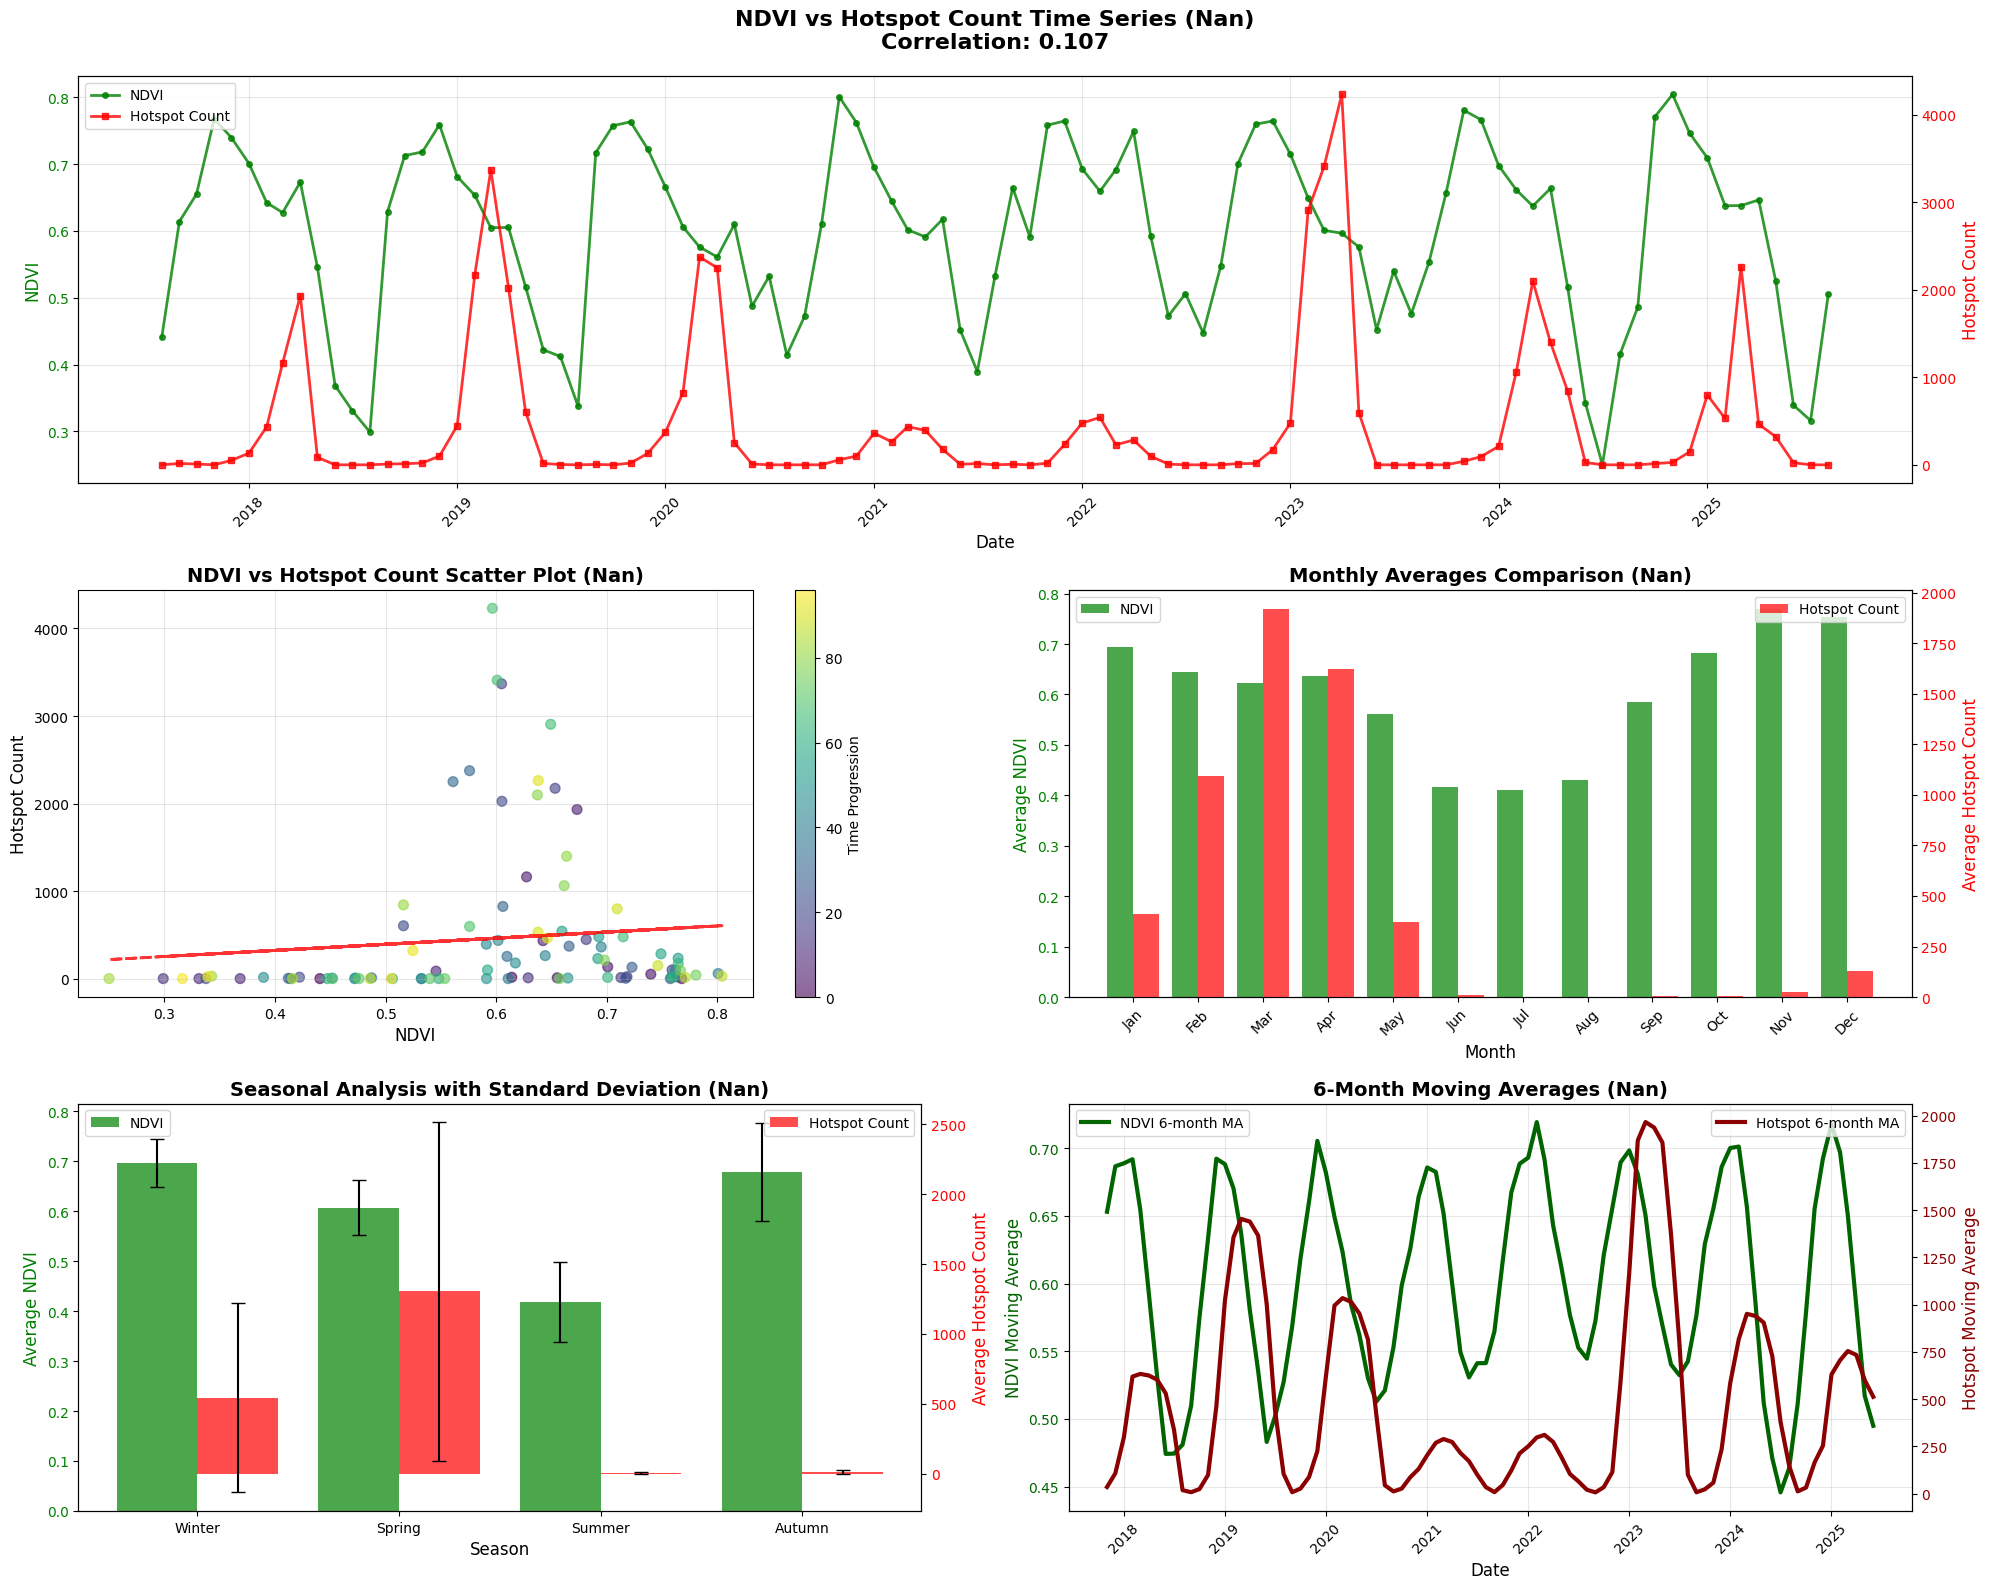


การวิเคราะห์ความสัมพันธ์ NDVI vs Hotspot Count
Pearson Correlation: 0.1075

Lag Correlation Analysis:
NDVI vs Hotspot (lag 1 months): -0.0422
NDVI vs Hotspot (lag 2 months): -0.3051
NDVI vs Hotspot (lag 3 months): -0.5188
NDVI vs Hotspot (lag 4 months): -0.6315
NDVI vs Hotspot (lag 5 months): -0.4337
NDVI vs Hotspot (lag 6 months): -0.0796

Seasonal Correlations:
Winter: -0.5138
Spring: 0.0054
Summer: -0.2081
Autumn: 0.6194
บันทึกกราฟ Yearly Comparison: Nan_yearly_comparison_analysis.png


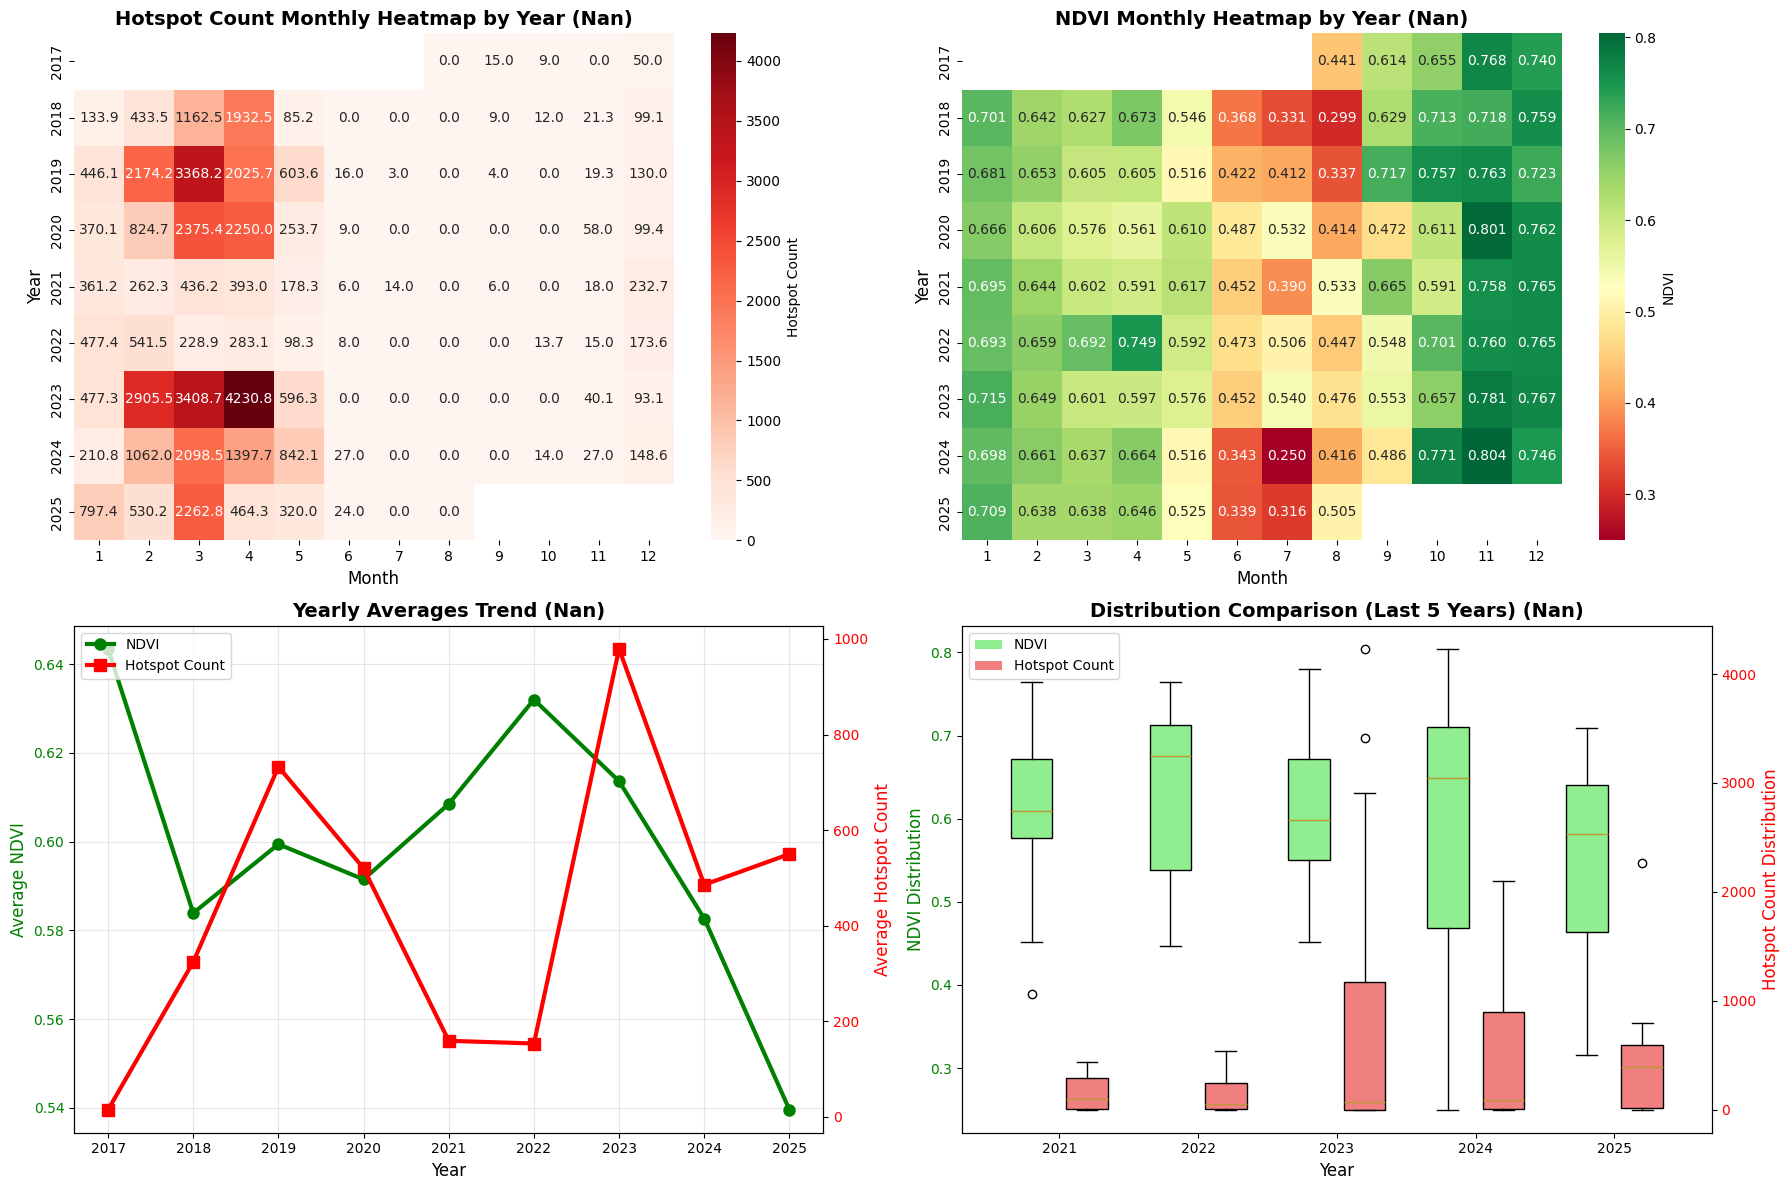


COMPREHENSIVE ANALYSIS REPORT: NDVI vs HOTSPOT COUNT

1. BASIC STATISTICS
----------------------------------------
            NDVI  hotspot_count
count  97.000000      97.000000
mean    0.598708     461.018678
std     0.132789     863.312774
min     0.249948       0.000000
25%     0.516131       0.000000
50%     0.617348      50.000000
75%     0.700792     446.086275
max     0.804225    4230.831373

2. CORRELATION ANALYSIS
----------------------------------------
Correlation Matrix:
                   NDVI  hotspot_count     month      year
NDVI           1.000000       0.107454  0.133176 -0.066159
hotspot_count  0.107454       1.000000 -0.495312  0.096975
month          0.133176      -0.495312  1.000000 -0.170163
year          -0.066159       0.096975 -0.170163  1.000000

Pearson Correlation Coefficient: 0.1075
P-value: 0.2948
Statistical Significance: No (α = 0.05)

3. SEASONAL ANALYSIS
----------------------------------------
Seasonal Statistics:
          NDVI                    

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Epoch 68: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
Epoch 73: early stopping
Restoring model weights from the end of the best epoch: 58.

กำลังสร้างกราฟ Learning Curve...


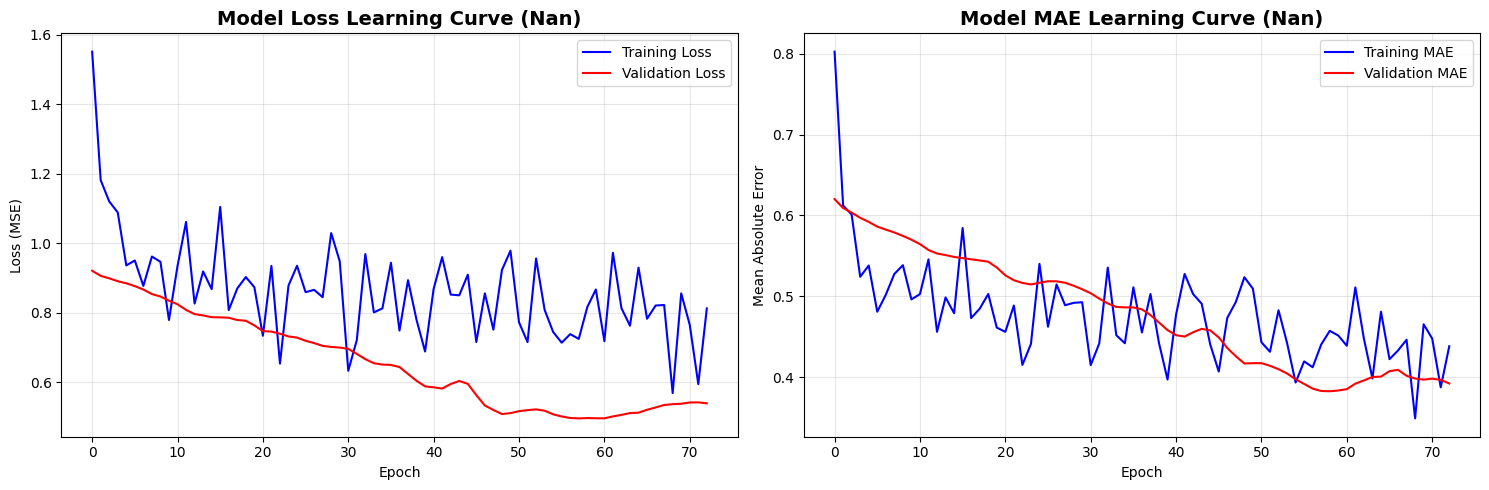

บันทึกกราฟ Learning Curve: learning_curve.png

กำลังประเมินแบบจำลอง...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 480ms/step
ผลการประเมินแบบจำลอง:
MSE: 187897.5488
RMSE: 433.4715
MAE: 328.7305
R²: 0.6159

กำลังสร้างกราฟ Actual vs Predicted...


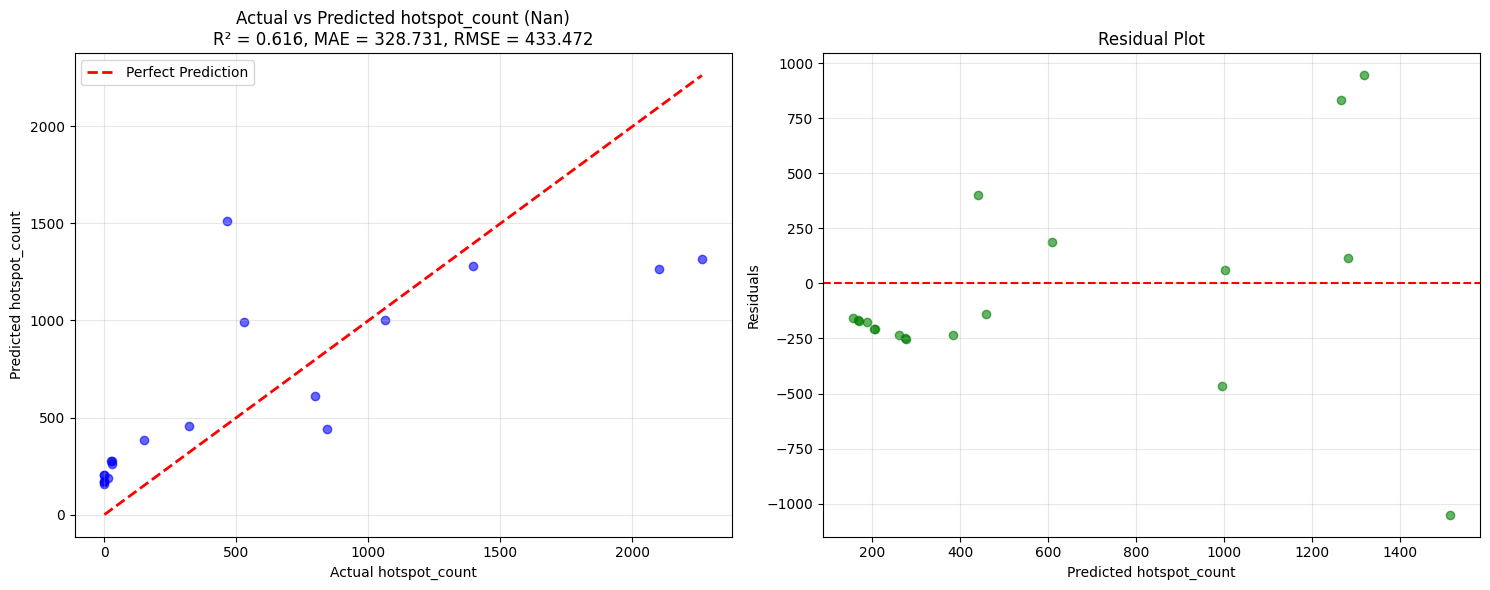

บันทึกกราฟ Actual vs Predicted: actual_vs_predicted.png

กำลังทำนาย 12 เดือนข้างหน้า...
การทำนายเสร็จสมบูรณ์!

กำลังสร้างตารางสรุปการทำนาย...

สรุปการทำนาย HOTSPOT COUNT รายเดือนสำหรับ 12 เดือนข้างหน้า
      Date     Month  Year  Predicted_hotspot_count Risk_Level     Season
2025-09-01 September  2025                    168.0  High Risk Wet Season
2025-10-01   October  2025                    158.0  High Risk Wet Season
2025-11-01  November  2025                    199.0  High Risk Wet Season
2025-12-01  December  2025                    301.0  High Risk Dry Season
2026-01-01   January  2026                    500.0  High Risk Dry Season
2026-02-01  February  2026                    875.0  High Risk Dry Season
2026-03-01     March  2026                   1310.0  High Risk Dry Season
2026-04-01     April  2026                   1293.0  High Risk Dry Season
2026-05-01       May  2026                    409.0  High Risk Dry Season
2026-06-01      June  2026                    273.0  High 

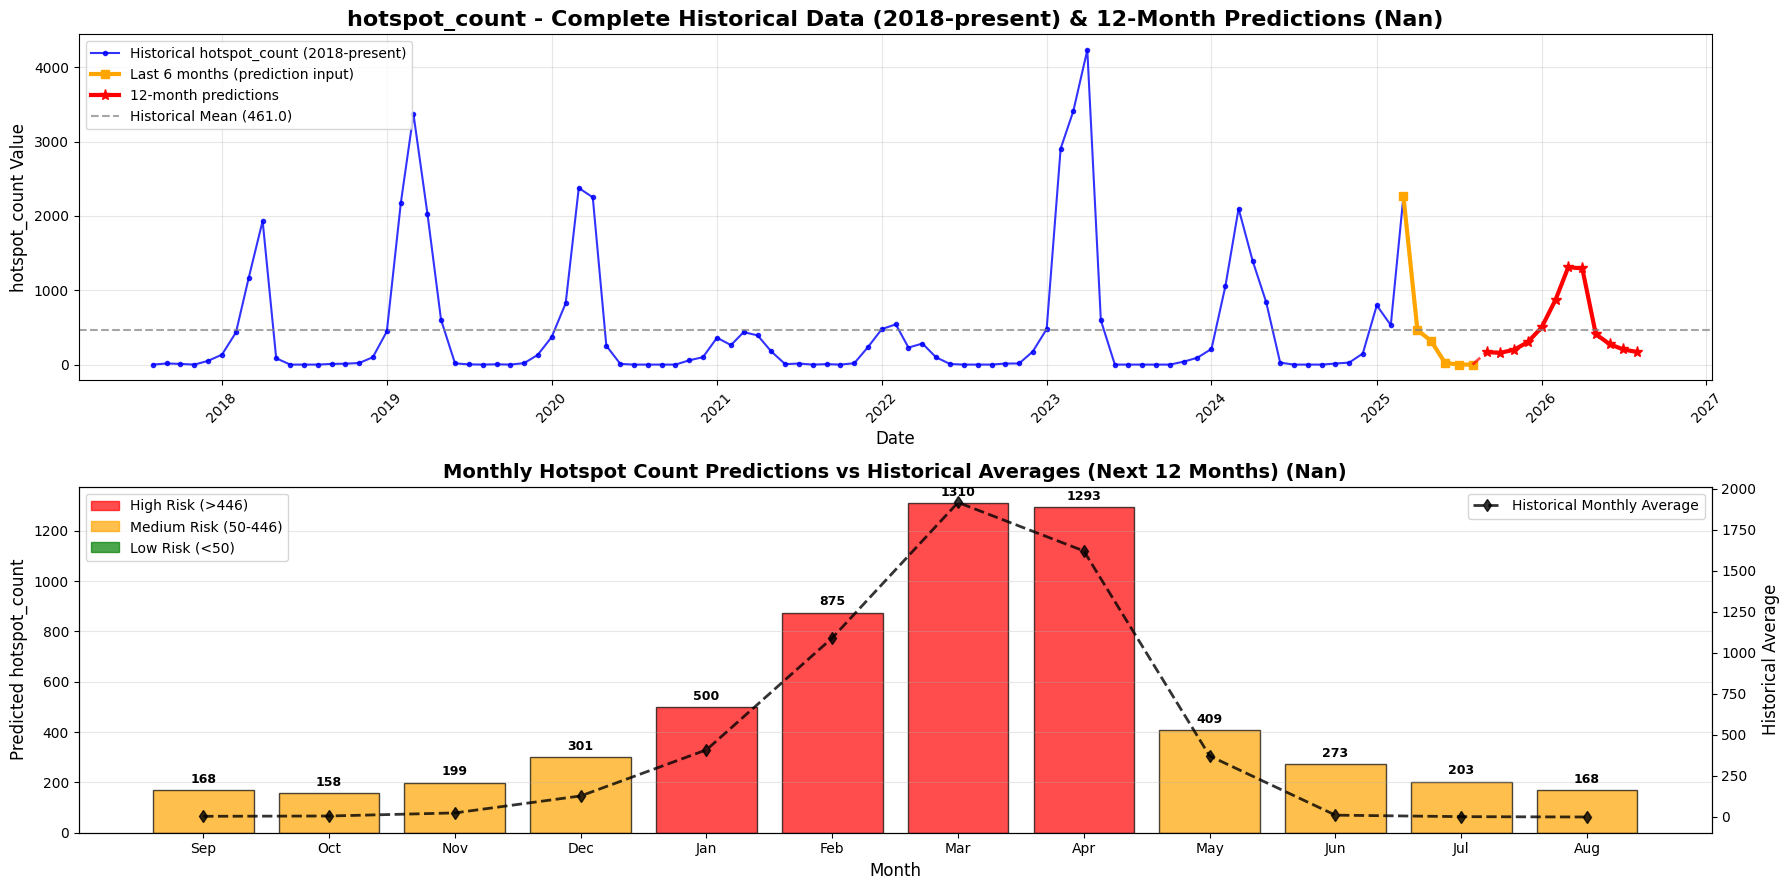

บันทึกกราฟทำนาย 12 เดือน: Nan_12_month_prediction.png

การเปรียบเทียบการทำนายกับค่าเฉลี่ยในอดีต:
Sep: ทำนาย 168, เฉลี่ยในอดีต 4.2, ต่าง +163.6 (+3849.6%) ↑ เพิ่มขึ้น
Oct: ทำนาย 158, เฉลี่ยในอดีต 6.1, ต่าง +151.7 (+2490.7%) ↑ เพิ่มขึ้น
Nov: ทำนาย 199, เฉลี่ยในอดีต 24.8, ต่าง +174.5 (+702.5%) ↑ เพิ่มขึ้น
Dec: ทำนาย 301, เฉลี่ยในอดีต 128.3, ต่าง +172.3 (+134.3%) ↑ เพิ่มขึ้น
Jan: ทำนาย 500, เฉลี่ยในอดีต 409.3, ต่าง +90.4 (+22.1%) ↑ เพิ่มขึ้น
Feb: ทำนาย 875, เฉลี่ยในอดีต 1091.7, ต่าง -216.5 (-19.8%) ↓ ลดลง
Mar: ทำนาย 1310, เฉลี่ยในอดีต 1917.7, ต่าง -607.8 (-31.7%) ↓ ลดลง
Apr: ทำนาย 1293, เฉลี่ยในอดีต 1622.1, ต่าง -328.7 (-20.3%) ↓ ลดลง
May: ทำนาย 409, เฉลี่ยในอดีต 372.2, ต่าง +36.7 (+9.9%) ↑ เพิ่มขึ้น
Jun: ทำนาย 273, เฉลี่ยในอดีต 11.2, ต่าง +262.1 (+2329.8%) ↑ เพิ่มขึ้น
Jul: ทำนาย 203, เฉลี่ยในอดีต 2.1, ต่าง +201.2 (+9469.8%) ↑ เพิ่มขึ้น
Aug: ทำนาย 168, เฉลี่ยในอดีต 0.0, ต่าง +168.3 (+0.0%) ↑ เพิ่มขึ้น

การวิเคราะห์และทำนาย HOTSPOT COUNT รายเดือนเสร็จสมบูรณ์!
ไฟล์ที่สร้าง:
  - learning_curv

In [14]:
# เรียกใช้ฟังก์ชันหลัก
if __name__ == "__main__":
    # Initialize Earth Engine (ต้องทำการ authenticate ก่อน)
    try:
        main()

    except Exception as e:
        print(f"ไม่สามารถเชื่อมต่อ Google Earth Engine ได้: {e}")
        print("กรุณาตรวจสอบ:")
        print("   1. การติดตั้ง earthengine-api")
        print("   2. การ authenticate: ee.Authenticate()")
        print("   3. การเชื่อมต่ออินเทอร์เน็ต")
